#Ablation Study: 1D causal layer into proposed TS-CausalNN Model


This notebook contains the proposed TS-CausalNN model with 1D custom calsal. We have developed the proposed Causal 1D layer to analyse the effectiveness of our proposed Causal Conv2D layer.
  

In this notebook, we applied the ablation 1D model to the synthetic dataset-1 to generate a full causal graph and summary graph.

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
data = pd.read_csv('/content/synthetic_data_v3.csv')

In [ ]:
data.iloc[0:5,:]

,S1,S2,S3,S4,S4_cf1,S4_cf0,S1_core,S2-core,S3-core,S4-core
0,1.891355,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000
1,1.900402,0.864968,0.186294,9.985518,9.985518,9.985518,1.990008,0.000000,0.000000,10.000000
2,1.929503,0.220185,-0.037330,10.338397,10.338397,10.338397,1.960133,0.000000,0.000000,10.000000
3,1.776680,1.804606,-1.533456,12.602538,2.069614,2.069990,1.910673,1.865288,-1.632127,11.703030
4,1.721463,4.807127,-2.538196,2.575272,0.870248,1.065671,1.842122,2.475918,-2.166429,1.793199


In [ ]:
true_graph = np.zeros((4,4))
true_graph[0,0]=1
true_graph[0,1]=1
true_graph[0,2]=1
true_graph[0,3]=1
true_graph[2,3]=1
true_graph[3,3]=1
true_graph

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
true_full_graph = np.zeros((4,24))
true_full_graph[0,0]=1
true_full_graph[0,12]=1
true_full_graph[1,16]=1
true_full_graph[2,16]=1
true_full_graph[3,16]=1
true_full_graph[3,18]=1
true_full_graph[3,19]=1
true_full_graph


array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 1., 1., 0., 0., 0., 0.]])

In [ ]:
!pip install cdt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.1/921.1 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=410319618b02367e5f4877c488ca90c1a5b5064e2a050cefdaef19b024d72118
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29253 sha256=4e612f084f7633cbeb2e841a06daeb8519167818da4995810372e03952e3b45d
  Stored in directory: /root/.cache/pip/wheels/dd/67/40/683074a684607162bd0e34dcf7ccdfcab5861c3b2a83286f3a
Successfully built GPUtil skrebate


In [ ]:
import cdt

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.


#Data Pre-processing

In [ ]:
import numpy as np
import pandas as pd

def data_preprocessing(data, max_lag=5):
  from sklearn.preprocessing import MinMaxScaler

  #convert to numpy array
  syn_data_np = data.to_numpy()

  #normalize the dataset
  scaler_X = MinMaxScaler(feature_range=(0, 1))
  syn_data_np_nor = scaler_X.fit_transform(syn_data_np)
  syn_data_np = syn_data_np_nor

  #transform into 2D data
  syn_data_np_T= syn_data_np.T
  syn_data_pro = np.zeros((syn_data_np.shape[0]-max_lag,syn_data_np.shape[1],(max_lag+1)))
  for i in range(0, (syn_data_np.shape[0]-max_lag)):
    syn_data_pro[i,:,:]= syn_data_np_T[:, i:i+(max_lag+1)]
  syn_data_2d = np.expand_dims(syn_data_pro, axis =-1)

  #make datafrom with normalized data
  syn_data_nor_df =pd.DataFrame(data = syn_data_np,
                  columns = data.columns)

  #transform normalized data into 1D shape with lagged and current time values
  size_1d = syn_data_np.shape[1]*(max_lag+1)
  print(size_1d)
  syn_data_1d = np.zeros((syn_data_np.shape[0]-max_lag,size_1d))
  for i in range(0, (syn_data_np.shape[0]-max_lag)):
    for j in range(0,(max_lag+1)):
      j_end = j * syn_data_np.shape[1]
      syn_data_1d[i,j_end:j_end+syn_data_np.shape[1]]= syn_data_np[i+j, :]

  #transform non-normalized data into 1D shape with lagged and current time values
  syn_data_np_2 = data.to_numpy()
  syn_data_1d_not_norm = np.zeros((syn_data_np_2.shape[0]-max_lag,size_1d))
  for i in range(0, (syn_data_np_2.shape[0]-max_lag)):
    for j in range(0,(max_lag+1)):
      j_end = j * syn_data_np_2.shape[1]
      syn_data_1d_not_norm[i,j_end:j_end+syn_data_np_2.shape[1]]= syn_data_np_2[i+j, :]


  return syn_data_np_nor, syn_data_2d, syn_data_nor_df, syn_data_1d,  syn_data_1d_not_norm

In [ ]:
syn_data_np, syn_data_2d, syn_data_nor_df, syn_data_1d, syn_data_1d_not_norm = data_preprocessing(data.iloc[:,:4], max_lag=5)

24


In [ ]:
syn_data_2d.shape

(99995, 4, 6, 1)

In [ ]:
syn_data_np.shape

(100000, 4)

In [ ]:
syn_data_nor_df.shape

(100000, 4)

In [ ]:
syn_data_1d.shape

(99995, 24)

In [ ]:
syn_data_1d_not_norm.shape

(99995, 24)

In [ ]:
syn_data_np.shape, syn_data_2d.shape

((100000, 4), (99995, 4, 6, 1))

In [ ]:
data_y_syn = syn_data_np[5:,0:4]
data_y_syn.shape

(99995, 4)

# Ablation TS-CausalNN Model with 1D Causal Layer

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, AveragePooling2D, LSTM, Activation, ConvLSTM2D, TimeDistributed, Input, Reshape
from keras.layers import UpSampling1D, Conv2DTranspose, UpSampling2D, Conv1D, AveragePooling1D, LeakyReLU
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
import keras.backend as K
import tensorflow as tf
from keras.layers import concatenate
from keras.regularizers import l1, l2
from time import time

keras.utils.set_random_seed(1001)

In [ ]:
class CausalDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs, counter, **kwargs):
    super(CausalDenseLayer, self).__init__()
    self.num_outputs = num_outputs
    self.counter = counter
    #self.name1=name1

  def build(self, input_shape):
    self.kernel = self.add_weight("kernel",
                                  shape=[int(input_shape[-1]), self.num_outputs],
                                  initializer = keras.initializers.RandomUniform(minval=0.05, maxval=0.5),
                                  #initializer = tf.keras.initializers.glorot_uniform(seed=1001),
                                  trainable=True)
    self.mask = np.ones(shape=self.kernel.shape)
    self.mask[-self.counter, ...] = 0.0
    #self.kernel(self.kernel * self.mask)

  def get_weights(self):
     return super().get_weights()

  def call(self, inputs):
    self.kernel.assign(self.kernel * self.mask)
    #return tf.matmul(inputs, self.kernel)
    return tf.keras.activations.tanh(tf.matmul(inputs, self.kernel))


In [ ]:
def get_model(input_dims):
    input_batch = Input(shape = input_dims)

    conv_model = Sequential()
    conv_model = Conv2D(filters=4, kernel_size=1, strides=(1,1), padding='valid', activation="linear", name='conv1')(input_batch)
    conv_model = tf.math.reduce_mean(conv_model, axis=-1)
    conv_model = Flatten()(conv_model )
    pooled_outputs = []
    for i in range(4, 0, -1):
      layer = CausalDenseLayer(num_outputs=1, counter=i, name="parr"+str(i))(conv_model)
      pooled_outputs.append(layer)
    output = concatenate(pooled_outputs)

    model = Model(inputs=input_batch, outputs=output, name='cpred')

    return model

In [ ]:

class CausalNNModel(object):
    def __init__(self,
                 dims,
                 alpha=0.0,
                 rho = 1.0,
                 rho_max = 10e20,
                 h_tol = 1e-8,
                 init='glorot_uniform'):

        super(CausalNNModel, self).__init__()

        self.dims = dims
        self.n_stacks = len(self.dims) - 1
        self.alpha = alpha
        self.rho = rho
        self.h_p = np.Inf
        self.rho_max = rho_max
        self.h_tol = h_tol
        self.model_1d = get_model(self.dims) #get_model_2d(self.dims)
        print("====Model created=====")

        self.model = Model(inputs=self.model_1d.input, outputs=self.model_1d.output)


    def custom_loss_function(self, y_true, y_pred):
      mse = keras.losses.mean_squared_error(y_true, y_pred)
      h_val = self.causal_loss_h()
      h_loss = 0.5 * self.rho * h_val * h_val + self.alpha * h_val
      lambda1 = 0.1
      adj_mat = self.get_mat()
      sparse_loss = lambda1 * tf.math.reduce_sum(tf.abs(adj_mat))
      print('MSE Loss is: {}, h Loss is: {}, L1 loss: {}, Total Loss is: {}'.format(tf.reduce_mean(mse), h_loss, sparse_loss, tf.reduce_mean(mse)+h_loss))
      return mse + h_loss + sparse_loss

    def causal_loss_h(self):
      mat = self.get_mat()
      h_val = self.h_acy_1(mat[:, 20:])
      return h_val

    def get_mat(self):
      w1_2d_s = self.model.get_layer(index=-5).get_weights()
      w2_2d_s = self.model.get_layer(index=-4).get_weights()
      w3_2d_s = self.model.get_layer(index=-3).get_weights()
      w4_2d_s = self.model.get_layer(index=-2).get_weights()
      arr1_2d_s = np.expand_dims(np.squeeze(np.array(w1_2d_s), axis=(0)).flatten('F'), axis=0)
      arr2_2d_s = np.expand_dims(np.squeeze(np.array(w2_2d_s), axis=(0)).flatten('F'), axis=0)
      arr3_2d_s = np.expand_dims(np.squeeze(np.array(w3_2d_s), axis=(0)).flatten('F'), axis=0)
      arr4_2d_s = np.expand_dims(np.squeeze(np.array(w4_2d_s), axis=(0)).flatten('F'), axis=0)
      mat_2d_s = np.concatenate((arr1_2d_s, arr2_2d_s, arr3_2d_s, arr4_2d_s))
      #print(mat_2d_s.shape)
      return mat_2d_s

    def h_acy_1(self, A):
      n_var = A.shape[0]
      h = tf.linalg.trace(tf.linalg.expm(A * A)) - n_var
      return h


    def h_acy(self, A):
      '''Calculate the constraint of A ensure that it's a DAG'''
      n_var = A.shape[0]
      M = tf.eye(n_var, num_columns = n_var) + A/n_var
      E = M
      for _ in range(n_var - 2):
        E = tf.linalg.matmul(E, M)
      h = tf.math.reduce_sum(tf.transpose(E) * M) - n_var
      return h

    def compile(self, optimizer='adam'):
        self.model.compile(optimizer=optimizer, loss= self.custom_loss_function) # ['mse', self.causal_loss()])

    def fit(self, x, y=None, maxiter=100, batch_size=512, save_dir='./results/temp'):
        t1 = time()
        import csv
        logfile = open(save_dir + '/causalnn_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter','loss'])
        logwriter.writeheader()
        train_loader = tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)
        optimizer = tf.keras.optimizers.Adam(1e-2)
        w1_2d_s = self.model.get_layer(index=-5).get_weights()
        arr1_2d_s = np.expand_dims(np.squeeze(np.array(w1_2d_s), axis=(0)).flatten('F'), axis=0)


        for epoch in range(int(maxiter)):
          print('Epoch: {}', epoch)
          h_n = None
          for (x, y) in train_loader:
            #eval loss and compute gradients
            with tf.GradientTape() as tape:
              tape.watch(self.model.trainable_variables)
              #passing through neural network
              output = self.model(x)
              #calculate loss
              loss = self.custom_loss_function(y, output)
              gradients = tape.gradient(loss, self.model.trainable_variables)
              optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
              h_n = self.causal_loss_h()


          if h_n > 0.25 * self.h_p:
                self.rho = self.rho*1.1
          self.h_p = h_n
          print('New h_val is :', h_n)
          self.alpha += self.rho * self.h_p

          if self.h_p <= self.h_tol or self.rho >= self.rho_max:
            print('Before the loop end # h_val is: {}, rho is: {}'.format(self.h_p, self.rho))
            break


        # save the trained model
        logfile.close()
        file_name  = "/CausalNN_model_final_" + str(round(time()))+ ".h5"
        print('saving model to:', save_dir + file_name)
        self.model.save_weights(save_dir + file_name)

        w1_2d_s_1 = self.model.get_layer(index=-5).get_weights()
        arr1_2d_s_1 = np.expand_dims(np.squeeze(np.array(w1_2d_s_1), axis=(0)).flatten('F'), axis=0)

        y_pred = self.model.predict(x)
        adj_mat = self.get_mat()

        print('The conv layer 1 weights before training :', arr1_2d_s)
        print('The conv layer 1 weights after training :', arr1_2d_s_1)

        return y_pred, adj_mat

#Model creation and training:

In [ ]:
keras.utils.set_random_seed(1001)

cnnmodel = CausalNNModel(dims=syn_data_2d.shape[1:])

====Model created=====


In [ ]:
cnnmodel.model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 4, 6, 1)]            0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 4, 6, 4)              8         ['input_10[0][0]']            
                                                                                                  
 tf.math.reduce_mean_9 (TFO  (None, 4, 6)                 0         ['conv1[0][0]']               
 pLambda)                                                                                         
                                                                                                  
 flatten_9 (Flatten)         (None, 24)                   0         ['tf.math.reduce_mean_9[

In [ ]:
cnnmodel.compile()

In [ ]:
y_pred, mat = cnnmodel.fit(x=syn_data_2d, y=data_y_syn, maxiter=20, batch_size=2048, save_dir='/content/')

Epoch: {} 0
MSE Loss is: 0.05786130577325821, h Loss is: 0.00030608641100116074, L1 loss: 2.4193241596221924, Total Loss is: 0.058167390525341034
MSE Loss is: 0.04318757355213165, h Loss is: 0.00040634474135003984, L1 loss: 2.5113232135772705, Total Loss is: 0.04359391704201698
MSE Loss is: 0.04103780537843704, h Loss is: 0.0005225077038630843, L1 loss: 2.592568874359131, Total Loss is: 0.04156031459569931
MSE Loss is: 0.043906692415475845, h Loss is: 0.0006127116503193974, L1 loss: 2.64115309715271, Total Loss is: 0.04451940581202507
MSE Loss is: 0.04610525071620941, h Loss is: 0.0006540311733260751, L1 loss: 2.6575119495391846, Total Loss is: 0.04675928130745888
MSE Loss is: 0.04526030272245407, h Loss is: 0.0006536862929351628, L1 loss: 2.651055097579956, Total Loss is: 0.04591399058699608
MSE Loss is: 0.04077969118952751, h Loss is: 0.0006262562819756567, L1 loss: 2.630131483078003, Total Loss is: 0.041405946016311646
MSE Loss is: 0.03863437473773956, h Loss is: 0.00058817444369196

Convert the predicted adjacency for visualization as a table.

In [ ]:
mat_df_2d_s = pd.DataFrame(mat)

In [ ]:
mat_f_df = pd.DataFrame(mat).T

In [ ]:
mat_df_2d_s.T

,0,1,2,3
0,-0.072227,0.003491,0.011898,-0.155254
1,0.050675,0.004964,-0.065854,-0.024597
2,-0.046424,-0.003724,0.074712,-0.163164
3,0.036899,-0.000860,-0.052911,1.047176
4,-0.002115,0.149346,0.641302,0.113260
5,2.200755,-0.009857,-0.050544,-0.012823
6,0.014374,-0.003460,-0.009262,-0.028512
7,-0.008694,-0.022078,-0.045547,0.020293
8,-0.011648,-0.014621,-0.013387,-0.054383
9,0.003822,-0.021322,-0.062979,-0.005246


#Full Causal Graph

In [ ]:
matrix_2d_2d_s = mat

In [ ]:
np.savetxt('ablation-1D-full-adj-mat_V3.csv', matrix_2d_2d_s, delimiter=",")

In [ ]:
import networkx as nx
G_2d_s = nx.DiGraph()

nodes_2d_s = ["S1(t-5)", "S2(t-5)", "S3(t-5)",  "S4(t-5)",
         "S1(t-4)", "S2(t-4)", "S3(t-4)",  "S4(t-4)",
         "S1(t-3)", "S2(t-3)", "S3(t-3)",  "S4(t-3)",
         "S1(t-2)", "S2(t-2)", "S3(t-2)",  "S4(t-2)",
         "S1(t-1)", "S2(t-1)", "S3(t-1)",  "S4(t-1)",
         "S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
nodes_r_2d_s=["S1(t)", "S2(t)", "S3(t)",  "S4(t)"]
pred_graph_f = np.zeros((4,24))

In [ ]:
for i in range (0, 24):
  G_2d_s.add_node(nodes_2d_s[i],pos=(int(i/4)+1,(i%4)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_s[j,i] > 0.3:
      print(i,j)
      G_2d_s.add_edge(nodes_2d_s[i], nodes_r_2d_s[j], weight=i)
      pred_graph_f[j,i]=1


3 3
4 2
5 0
11 1
16 3
17 2
17 3


In [ ]:
pos_2d_s=nx.get_node_attributes(G_2d_s,'pos')
pos_2d_s

{'S1(t-5)': (1, 1),
 'S2(t-5)': (1, 2),
 'S3(t-5)': (1, 3),
 'S4(t-5)': (1, 4),
 'S1(t-4)': (2, 1),
 'S2(t-4)': (2, 2),
 'S3(t-4)': (2, 3),
 'S4(t-4)': (2, 4),
 'S1(t-3)': (3, 1),
 'S2(t-3)': (3, 2),
 'S3(t-3)': (3, 3),
 'S4(t-3)': (3, 4),
 'S1(t-2)': (4, 1),
 'S2(t-2)': (4, 2),
 'S3(t-2)': (4, 3),
 'S4(t-2)': (4, 4),
 'S1(t-1)': (5, 1),
 'S2(t-1)': (5, 2),
 'S3(t-1)': (5, 3),
 'S4(t-1)': (5, 4),
 'S1(t)': (6, 1),
 'S2(t)': (6, 2),
 'S3(t)': (6, 3),
 'S4(t)': (6, 4)}

In [ ]:
weights_2d_s = nx.get_edge_attributes(G_2d_s,'weight').values()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


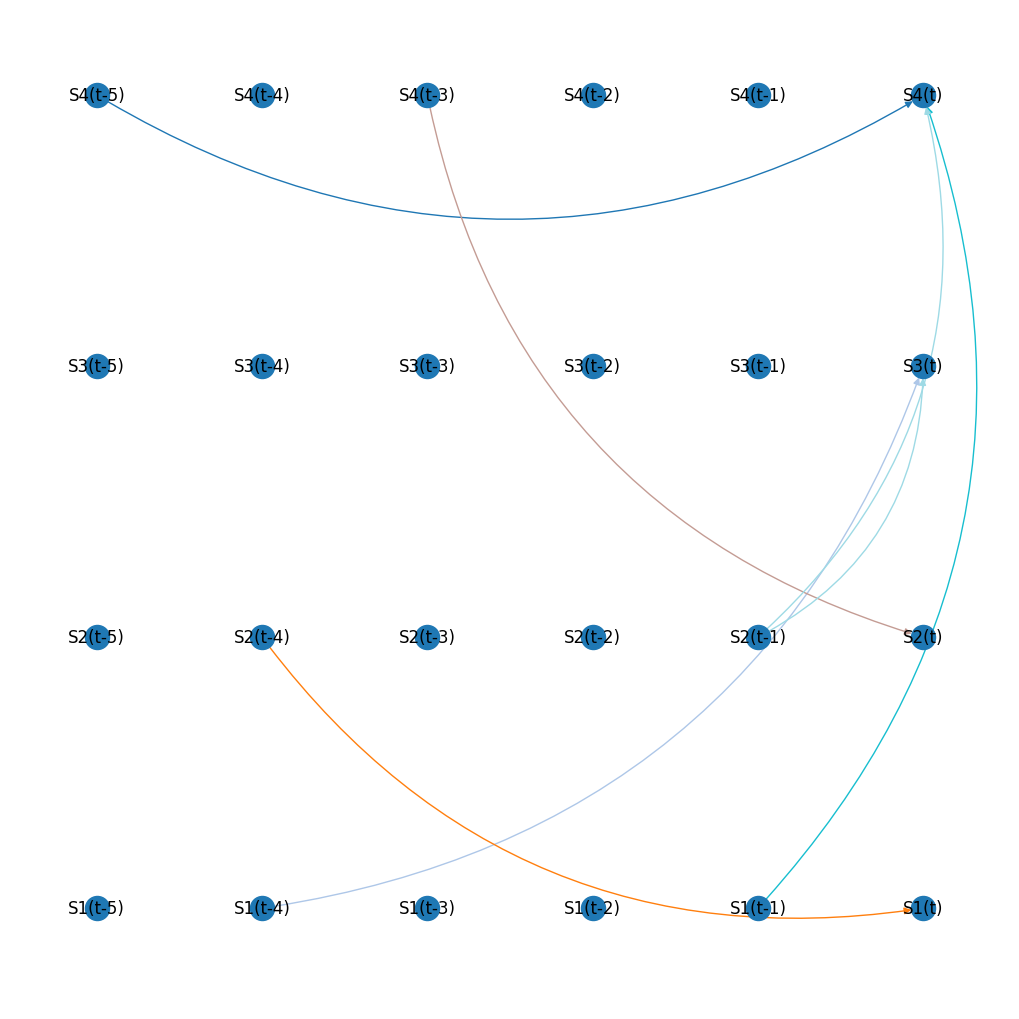

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
nx.draw(G_2d_s, pos_2d_s, cmap = plt.get_cmap('jet'), edge_cmap= plt.cm.tab20, edge_color=weights_2d_s, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.show()

In [ ]:
pred_graph_f

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0.]])

In [ ]:
cdt.metrics.SHD(true_full_graph, pred_graph_f)

12.0

In [ ]:
true_values = true_full_graph
predictions = pred_graph_f

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.875, Precision: 0.14285714285714285, Recall: 0.14285714285714285, FDR: 0.8571428571428571, F1 Score: 0.14285714285714285


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1), normalize=True)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("Precision:", precision)

# Calculate recall (sensitivity)
recall = recall_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("Recall (Sensitivity):", recall)

# Calculate F1-score
f1 = f1_score(true_full_graph.reshape(-1), pred_graph_f.reshape(-1))
print("F1-Score:", f1)

Accuracy: 0.875
Precision: 0.3076923076923077
Recall (Sensitivity): 0.5714285714285714
F1-Score: 0.4


#Summary Causal Graph

In [ ]:
import networkx as nx
G_2d_s1 = nx.DiGraph()

nodes_2d_s1 = ["S1", "S2", "S3",  "S4"]
nodes_r_2d_s1= ["S1", "S2", "S3",  "S4"]
edges_2d_s1 = []
pred_graph_s1 = np.zeros((4,4))

In [ ]:
for i in range (0, 4):
  G_2d_s1.add_node(nodes_2d_s1[i],pos=(int(i/2)+1,(i%2)+1))

In [ ]:
for i in range(0, 24):
  for j in range (0, 4):
    if matrix_2d_2d_s[j,i] > 0.3:
      col = np.round(matrix_2d_2d_s[j,i], 2)
      print(i,j, col)
      G_2d_s1.add_edge(nodes_2d_s1[i%4], nodes_r_2d_s1[j], weight=1)
      pred_graph_s1[i%4, j]=1


3 3 1.05
4 2 0.64
5 0 2.2
11 1 2.6
16 3 0.33
17 2 2.18
17 3 0.82


In [ ]:
pos_2d_s1=nx.get_node_attributes(G_2d_s1,'pos')
pos_2d_s1

{'S1': (1, 1), 'S2': (1, 2), 'S3': (2, 1), 'S4': (2, 2)}

In [ ]:
weights_2d_s1 = nx.get_edge_attributes(G_2d_s1,'weight').values()

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


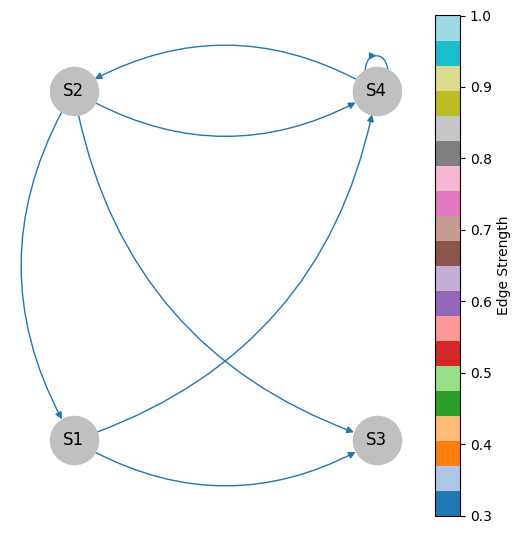

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.figure(figsize=(5, 5))
nx.draw(G_2d_s1, pos_2d_s1,  edge_cmap= plt.cm.tab20,  #cmap = plt.get_cmap('jet'),
        font_size=12, node_size=1200, node_color='#c0c0c0', #[30,30,30,30,30],
        edge_color=weights_2d_s1, with_labels = True, connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx(G, with_labels = True)
plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0.3, 1), cmap=plt.cm.tab20),
              orientation='vertical', label='Edge Strength')
plt.show()

In [ ]:
cdt.metrics.SHD(true_graph, pred_graph_s1) # initi-1, linear, tanh, 20, 0.3

7.0

In [ ]:
pred_graph_s1

array([[0., 0., 1., 1.],
       [1., 0., 1., 1.],
       [0., 0., 0., 0.],
       [0., 1., 0., 1.]])

In [ ]:
true_graph

array([[1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [ ]:
np.savetxt('proposed-summary-adj-mat.csv', pred_graph_s1, delimiter=",")

In [ ]:
true_values = true_graph
predictions = pred_graph_s1

N = true_values.shape[1]*true_values.shape[0]
accuracy = (true_values == predictions).sum() / N
TP = ((predictions == 1) & (true_values == 1)).sum()
FP = ((predictions == 1) & (true_values == 0)).sum()
TN = ((predictions == 0) & (true_values == 0)).sum()
FN = ((predictions == 0) & (true_values == 1)).sum()
precision = TP / (TP+FP)
recall = TP / (TP + FN)
FDR = FP / (FP + TP)
F1 = 2 * (precision * recall) / (precision + recall)
print('Accuracy: {}, Precision: {}, Recall: {}, FDR: {}, F1 Score: {}'.format(accuracy, precision, recall, FDR,F1))

Accuracy: 0.5625, Precision: 0.42857142857142855, Recall: 0.5, FDR: 0.5714285714285714, F1 Score: 0.4615384615384615
